# FPGheArt - Week 5 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653


For the sake of simplicity and beauty, we built a class for defining RBMs instead of coding the class itself inside the notebook. 

Of course, the RBM.py script **MUST** to be included for the following code to work properly.

At the beginning of the notebook we also want to clarify how the RBM methods work.

- *fit* : fits the model accordingly to the data passed as argument
- *score*: returns the percentage of samples denoised, so the reconstructed fantasy data that actually match one of the initial sequences (not necessarily the right one). Basically it __CHECKS__ the existence of the sample among the original ones.
- *compare*: returns the percentage of samples **CORRECTLY** denoised, so the ones that actually are sent back to the their original and denoised sequence. 

__ATTENTION:__ The whole notebook takes some times to be runned

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import RBM as rbm
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Useful functions

In [2]:
def load(fname, spins= True):
    v = np.loadtxt(fname, delimiter=",", dtype = int)
    if spins:
        vmin = -1
        GAP = 2
        v = 2*v - 1
    else:
        vmin = 0
        GAP = 1
    return v.copy()

def create_coord(np, x0):
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5
    return (x, y)

def mycolor(val):
    if val > 0:
        return 'red'
    elif val < 0:
        return 'blue'
    return 'black'

def plotgraph(w, a, b, epoch=0, M = 3, L = 8):
    A = 2./w.max()
    (x1, y1) = create_coord(L, 0)
    (x2, y2) = create_coord(M, 1)
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder = 1, lw=A*np.abs(w[i][j]))
    A = 300./(a.max() + b.max())
    for i in range(L):
        plt.scatter(x1[i], y1[i], s = A*np.abs(a[i]), zorder = 2, c = mycolor(a[i]))
    for j in range(M):
        plt.scatter(x2[j], y2[j], s = A*np.abs(b[j]), zorder = 2, c = mycolor(b[j]))
    plt.title(f">0 red, <0 blue, epoch = {epoch}")
    plt.show()
    
def noise_score(seq):
    for n in range(N):
        for i in range(len(seq)):
            if (v0[n] == seq[i]).all():
                count += 1
                break

## Data load

The starting point is the 4-sequences file load.

In [3]:
q=0.1
fname = "DATA/dataRBM_seq4_q" + str(q) + ".csv"
v = load(fname)
#store initial values
v0 = v.copy()

Sequences themselves will be needed in order to estimate the quality of the results.

In [4]:
seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))] #spins=True, so *2-1 factor

## RBM application

The first RBM is the one built during the lesson, having three hidden nodes, 50 epochs, learning rate equal to 1 and a minibatch of 500 samples. From now on this will be the default model. 

In [5]:
my_rbm = rbm.RBM(random_state = 123)
my_rbm.fit(v)

The *plotgraph* function is useful in order to visualize the weights.

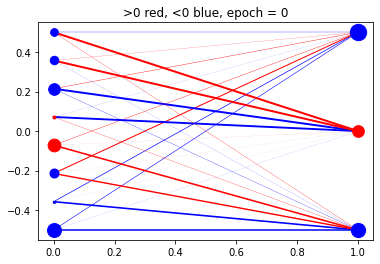

In [6]:
plotgraph(*(my_rbm.params()))

 It seems that only two nodes are relevant for the computation; for the sake of simplicity the model we can use only two hidden nodes.
 
Such a result of course is linked to the way data are generated introducing redundancy.

In [7]:
my_rbm = rbm.RBM(M=2, random_state = 12)
my_rbm.fit(v)

From the following plot we can see a weight structure that highlights the RBM's pattern recognition - basically the four input couples.

Weights are correlated in pairs, and the two hidden nodes focus only on half of the initial data.

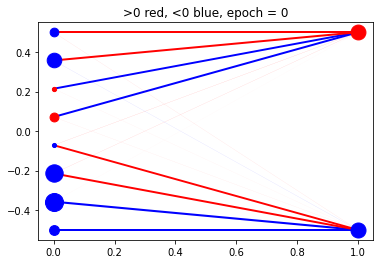

In [8]:
plotgraph(*(my_rbm.params()), M=2)

In order to measure the performance of the RBM the score method is exploited. 

This function returns the fraction of samples that match one of the original sequences. After training with $\beta = 1$, different values are considered to generate back the fantasy data in the negative phase.

In [9]:
betas = list(np.arange(1,10,0.1))

In [10]:
scores_b = []
for beta in betas:
    scores_b.append(my_rbm.score(v,seq, beta = beta))

We can also try changing $\beta$ in the positive phase.

In [11]:
scores_bh = []
for beta in betas:
    scores_bh.append(my_rbm.score(v,seq, beta = beta, beta_h = beta))

In [12]:
scores_h = []
for beta in betas:
    scores_h.append(my_rbm.score(v,seq, beta_h = beta))

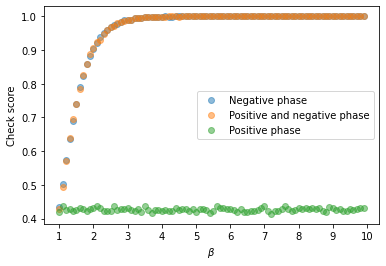

In [13]:
plt.scatter(betas, scores_b, marker = 'o', label = 'Negative phase', alpha = 0.5)
plt.scatter(betas, scores_bh, marker = 'o', label = 'Positive and negative phase', alpha = 0.5)
plt.scatter(betas, scores_h, marker = 'o', label = 'Positive phase', alpha = 0.5)
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Check score')
plt.legend()
plt.show()

The plot displays the fact than, using $\beta > 3$, all the samples are brought back to one of the original sequences - even if not necessarily their original one. Using the $\beta$ parameter also in positive phase does not change the performaces. 
Moreover, whether the $\beta$ is used only in the positive phase the check score stays almost constant, equal to the one with $\beta = 1$. One can deduce that this parameter is not relevant in generating the new data.

From now on we use the $\beta$ parameter only in the negative phase.

In order to _compare_ the fantasy data to the corresponding original sequences, the *compare* method is exploited - it basically counts the number of correctly denoised samples. The argument of the function are the original "clean" data, the same ones with some noise and the $\beta$ parameters. 



In [14]:
q=0.1
fname = "DATA/dataRBM_clean4_q" + str(q) + ".csv"
v_c = load(fname)

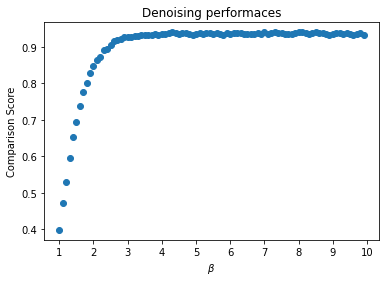

In [15]:
scores_comp = []
for beta in betas:
    scores_comp.append(my_rbm.compare(v0,v_c, beta = beta))

plt.scatter(betas, scores_comp)
plt.title('Denoising performaces')
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Comparison Score')
plt.show()

The RBM with two nodes has good performances in denoising for $\beta$ higher than 3. The comparison score has a similar $\beta$ dependance to the previous one, as expected.

It is worth noticing that in the previous case the sequences were perfectly denoised in one of the 4 original ones, while in this try instead the performances tops at $\sim 0.9$ as some of them are not linked to their original one.

In the next cell the confusion matrix is reported

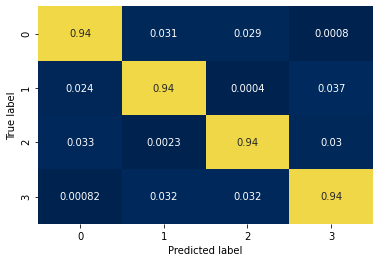

In [16]:
y = []
for n in range(len(v_c)):
    for i in range(len(seq)):
        if (v_c[n] == seq[i]).all():
                y.append(i)
                break

sns.heatmap(confusion_matrix(y, my_rbm.predict(v0,seq, beta = 60), normalize = "true"), annot=True, vmin = 0, vmax =1, cbar = False, yticklabels=list(range(4)), xticklabels=list(range(4)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

## Analysis on different number of hidden layers

In this section a comparison on how the performances change using different numbers of hidden nodes is proposed.

In [17]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v))

As the effective performances change with differet betas three values are used for each different M. 

Moreover graphs for both the compare and score function will be provided.

In [18]:
M_score_b1 = []
M_score_b2 = []
M_score_b3 = []
for rb in rbms:
    M_score_b1.append(rb.score(v0,seq, beta = 1))
    M_score_b2.append(rb.score(v0,seq, beta = 5))
    M_score_b3.append(rb.score(v0,seq, beta = 9))

In [19]:
M_compare_b1 = []
M_compare_b2 = []
M_compare_b3 = []
for rb in rbms:
    M_compare_b1.append(rb.compare(v0,v_c, beta = 1))
    M_compare_b2.append(rb.compare(v0,v_c, beta = 5))
    M_compare_b3.append(rb.compare(v0,v_c, beta = 9))

Text(69.0, 0.5, '$\\beta$')

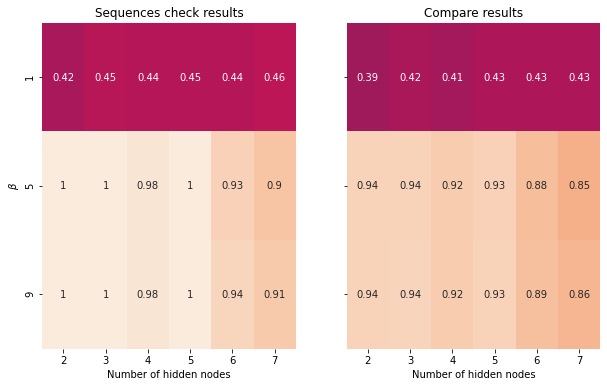

In [20]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
matr_score = [M_score_b1,M_score_b2,M_score_b3]
matr_compare = [M_compare_b1,M_compare_b2,M_compare_b3]
sns.heatmap(matr_score, annot=True, cbar = False, ax = ax[0], yticklabels=[1,5,9] , xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
sns.heatmap(matr_compare, annot=True, cbar = False, ax = ax[1], yticklabels=[1,5,9], xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
ax[0].set_xlabel("Number of hidden nodes")
ax[1].set_xlabel("Number of hidden nodes")
ax[0].set_title("Sequences check results")
ax[1].set_title("Compare results")
ax[0].set_ylabel(r"$\beta$")

As explicited in the previous figure, different RMBs have quite similar performances.

In general it is possibie to say that a lower number of hidden nodes increases the performances - and increasing the number of nodes more than five leads to poorer performances.

The following cell can be used to plot the coefficients for chosen configuration.

## Analysis on data generated from 5 sequences

In the section a study on how the RBM works on data containing 5 different sequences is displayed.

In [21]:
q=0.1
fname = "DATA/dataRBM_seq5_q" + str(q) + ".csv"
v_5 = load(fname)

seqstr = ['11001100', '00111100', '11000011', '00110011', '11111111']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
v0_5 = v_5.copy()

In [22]:
q=0.1
fname = "DATA/dataRBM_clean5_q" + str(q) + ".csv"
v5_c = load(fname)

y_5 = []
for n in range(len(v5_c)):
    for i in range(len(seq)):
        if (v5_c[n] == seq[i]).all():
                y_5.append(i)
                break

As before we will check the performances over different M selections.

In [23]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v_5))
    #plotgraph(*(my_rbm.params()), M=M)

In [24]:
M_score_b1 = []
M_score_b2 = []
M_score_b3 = []
M_score_b4 = []

for rb in rbms:
    M_score_b1.append(rb.score(v0_5,seq, beta = 1))
    M_score_b2.append(rb.score(v0_5,seq, beta = 5))
    M_score_b3.append(rb.score(v0_5,seq, beta = 9))
    M_score_b4.append(rb.score(v0_5,seq, beta = 15))

In [25]:
M_compare_b1 = []
M_compare_b2 = []
M_compare_b3 = []
M_compare_b4 = []

for rb in rbms:
    M_compare_b1.append(rb.compare(v0_5,v5_c, beta = 1))
    M_compare_b2.append(rb.compare(v0_5,v5_c, beta = 5))
    M_compare_b3.append(rb.compare(v0_5,v5_c, beta = 9))
    M_compare_b4.append(rb.compare(v0_5,v5_c, beta = 15))

Text(69.0, 0.5, '$\\beta$')

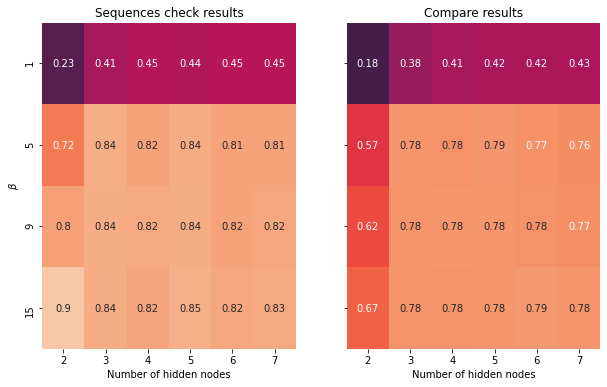

In [26]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
matr_score = [M_score_b1,M_score_b2,M_score_b3, M_score_b4]
matr_compare = [M_compare_b1,M_compare_b2,M_compare_b3,M_compare_b4]
sns.heatmap(matr_score, annot=True, cbar = False, ax = ax[0], yticklabels=[1,5,9,15] , xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
sns.heatmap(matr_compare, annot=True, cbar = False, ax = ax[1], yticklabels=[1,5,9,15], xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
ax[0].set_xlabel("Number of hidden nodes")
ax[1].set_xlabel("Number of hidden nodes")
ax[0].set_title("Sequences check results")
ax[1].set_title("Compare results")
ax[0].set_ylabel(r"$\beta$")

Looking at the compare table, the best result is obtained with a number of hidden nodes higher than 3. It is noticeable that introducing a new sequence lowers the performances for two-nodes machines.

Moreover using $\beta = 1$ the compare scores are lower with respect to the lower temperature cases. 

Finally, introducing a new sequence leads RBMs to have poorer performances than in 4-sequences case.

In the following confusion matrices of performances over different input sequences is displayed.

These graphs help understand how the model behaves when it tries to classify the different sequences. Notice that the label $-1$ is introduced to keep track of the noised samples that are not correctly denoised and do not match any of the original sequences.

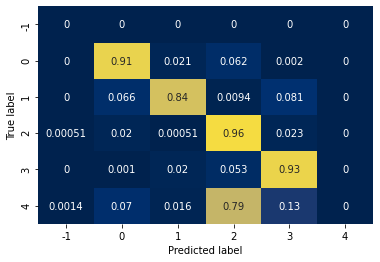

In [27]:
sns.heatmap(confusion_matrix(y_5, rbms[0].predict(v0_5,seq, beta = 60), normalize = "true"), annot=True, vmin = 0, vmax =1, cbar = False, yticklabels=list(range(-1,5)), xticklabels=list(range(-1,5)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

Using only **2 nodes** one can see that the fourth label is never predicted and it gets confused most times with the third one.

This network can recognize only the four classes previously seen, and by the way in solving this task it reaches the same accuracy it had before.

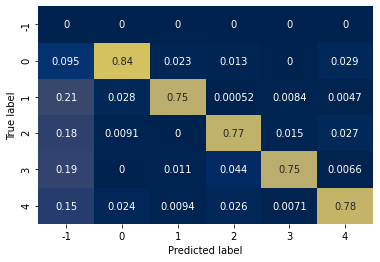

In [28]:
sns.heatmap(confusion_matrix(y_5, rbms[1].predict(v0_5,seq, beta = 60), normalize = "true"), annot=True, vmin = 0, vmax =1, cbar = False, yticklabels=list(range(-1,5)), xticklabels=list(range(-1,5)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

By increasing the number of nodes the overall performances increase, since the RBM starts recognizing the fifth label. Nevertheless the specific performances on the first four classes shrinks, and all the misclassified samples are not associated to a label.

## Analysis on data generated from 6 sequences

In this section we will exploit the same procedure as before

In [29]:
q=0.1
fname = "DATA/dataRBM_seq6_q" + str(q) + ".csv"
v_6 = load(fname)

seqstr = ['11001100', '00111100', '11000011', '00110011', '11111111',  '10101000']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
v0_6 = v_6.copy()

In [30]:
q=0.1
fname = "DATA/dataRBM_clean6_q" + str(q) + ".csv"
v6_c = load(fname)

y_6 = []
for n in range(len(v5_c)):
    for i in range(len(seq)):
        if (v6_c[n] == seq[i]).all():
                y_6.append(i)
                break

In [31]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v_6))
    #plotgraph(*(my_rbm.params()), M=M)

In [32]:
M_score_b1 = []
M_score_b2 = []
M_score_b3 = []
for rb in rbms:
    M_score_b1.append(rb.score(v0_6,seq, beta = 6))
    M_score_b2.append(rb.score(v0_6,seq, beta = 30))
    M_score_b3.append(rb.score(v0_6,seq, beta = 100))

/home/filippo/Documents/POD/LOCPB/Week5/RBM.py:140: RuntimeWarning: overflow encountered in exp
  prob = 1./(1.+np.exp(-beta*DE*act))


In [33]:
M_compare_b1 = []
M_compare_b2 = []
M_compare_b3 = []
for rb in rbms:
    M_compare_b1.append(rb.compare(v0_6,v6_c, beta = 6))
    M_compare_b2.append(rb.compare(v0_6,v6_c, beta = 30))
    M_compare_b3.append(rb.compare(v0_6,v6_c, beta = 100))

Text(69.0, 0.5, '$\\beta$')

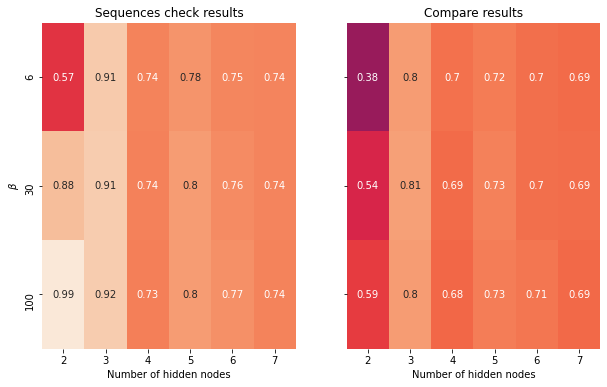

In [34]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
matr_score = [M_score_b1,M_score_b2,M_score_b3]
matr_compare = [M_compare_b1,M_compare_b2,M_compare_b3]
sns.heatmap(matr_score, annot=True, cbar = False, ax = ax[0], yticklabels=[6,30,100] , xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
sns.heatmap(matr_compare, annot=True, cbar = False, ax = ax[1], yticklabels=[6,30,100], xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
ax[0].set_xlabel("Number of hidden nodes")
ax[1].set_xlabel("Number of hidden nodes")
ax[0].set_title("Sequences check results")
ax[1].set_title("Compare results")
ax[0].set_ylabel(r"$\beta$")

Analysing 6-sequences data, the best result is obtained with a number of hidden nodes equal to 3.

Introducing another sequence drops again the performances for a two-nodes machine. Also, performances are worse for an higher number of hidden nodes.

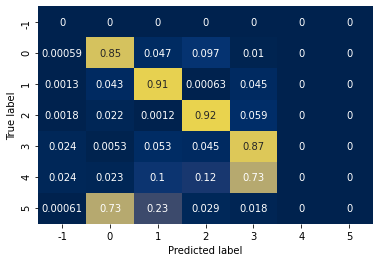

In [35]:
sns.heatmap(confusion_matrix(y_6,rbms[0].predict(v0_6,seq, beta = 100), normalize = "true"), annot=True, cbar = False, vmin = 0, vmax =1, yticklabels=list(range(-1,6)), xticklabels=list(range(-1,6)), cmap = "cividis")

plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

As expected with two hidden nodes, the RBM is only able to recognize the first 4 sequences.

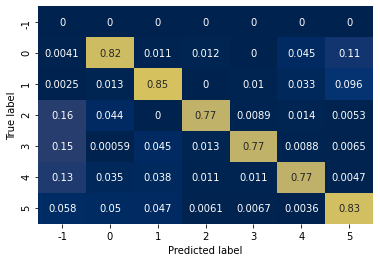

In [36]:
sns.heatmap(confusion_matrix(y_6, rbms[1].predict(v0_6,seq, beta = 100), normalize = "true"), annot=True, cbar = False, vmin = 0, vmax =1, yticklabels=list(range(-1,6)), xticklabels=list(range(-1,6)), cmap = "cividis")

plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

The best result is obtained with three hidden nodes, for which the scores are largely homogeneous.

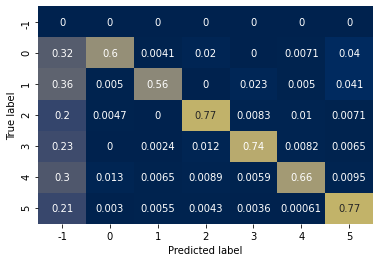

In [37]:
sns.heatmap(confusion_matrix(y_6, rbms[2].predict(v0_6,seq, beta = 100), normalize = "true"), annot=True, cbar = False, vmin = 0, vmax =1,  yticklabels=list(range(-1,6)), xticklabels=list(range(-1,6)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

For a number of hidden layer higher than three, the network is more uncertain and many sequences are not correctly denoised - in accordance to the previous plot.

## Data generated with error rate q = 0.2

One can use different magnitude of noise to check the denoising capability of the RBM. We expect to have worse results while increasing the error rate.

### Analysis on data generated from 4 sequences

In [38]:
q=0.2
fname = "DATA/dataRBM_seq4_q" + str(q) + ".csv"
v = load(fname)
v0 = v.copy()

seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]

q=0.2
fname = "DATA/dataRBM_clean4_q" + str(q) + ".csv"
v_c = load(fname)

y_4_q02 = []
for n in range(len(v_c)):
    for i in range(len(seq)):
        if (v_c[n] == seq[i]).all():
                y_4_q02.append(i)
                break

In [39]:
my_rbm = rbm.RBM(M=2, random_state = 12)
my_rbm.fit(v)

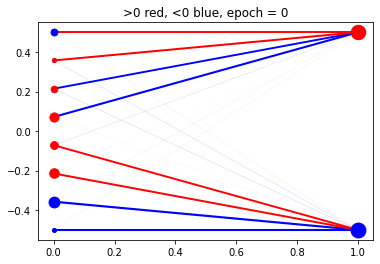

In [40]:
plotgraph(*(my_rbm.params()), M=2)

Also in this case one may try different values for beta to see if the score has any improvement.

In [41]:
betas = list(np.arange(1,10,0.1))

In [42]:
scores_b = []
for beta in betas:
    scores_b.append(my_rbm.score(v,seq, beta = beta))

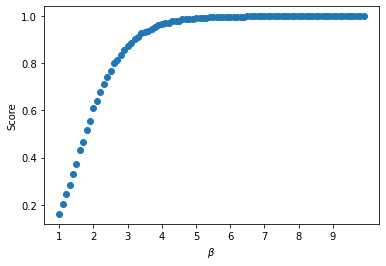

In [43]:
plt.scatter(betas, scores_b)
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 10, 1))
plt.ylabel('Score')
plt.show()

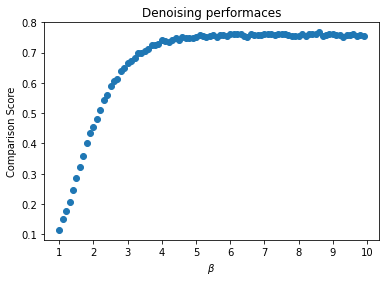

In [44]:
scores_comp = []
for beta in betas:
    scores_comp.append(my_rbm.compare(v0,v_c, beta = beta))

plt.scatter(betas, scores_comp)
plt.title('Denoising performaces')
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Comparison Score')
plt.show()

While on the one hand the denoising performance again reaches one, on the other hand the denosing one tops slightly above 0.7. 
There is then a clear influence of this increase of the noise in the actual performances of the algorithm.

For the sake of completeness one can use multiple numbers of hidden nodes also in this case and evaluate the performances.

In [49]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v))

In [50]:
M_score_b1 = []
M_score_b2 = []
M_score_b3 = []
M_score_b4 = []
for rb in rbms:
    M_score_b1.append(rb.score(v0,seq, beta = 1))
    M_score_b2.append(rb.score(v0,seq, beta = 5))
    M_score_b3.append(rb.score(v0,seq, beta = 9))
    M_score_b4.append(rb.score(v0,seq, beta = 15))


In [51]:
M_compare_b1 = []
M_compare_b2 = []
M_compare_b3 = []
M_compare_b4 = []
for rb in rbms:
    M_compare_b1.append(rb.compare(v0,v_c, beta = 1))
    M_compare_b2.append(rb.compare(v0,v_c, beta = 5))
    M_compare_b3.append(rb.compare(v0,v_c, beta = 9))
    M_compare_b4.append(rb.compare(v0,v_c, beta = 15))


Text(69.0, 0.5, '$\\beta$')

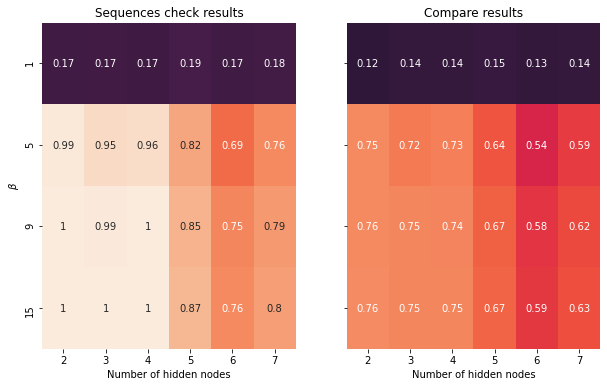

In [52]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
matr_score = [M_score_b1,M_score_b2,M_score_b3,M_score_b4]
matr_compare = [M_compare_b1,M_compare_b2,M_compare_b3,M_compare_b4]
sns.heatmap(matr_score, annot=True, cbar = False, ax = ax[0], yticklabels=[1,5,9,15] , xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
sns.heatmap(matr_compare, annot=True, cbar = False, ax = ax[1], yticklabels=[1,5,9,15], xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
ax[0].set_xlabel("Number of hidden nodes")
ax[1].set_xlabel("Number of hidden nodes")
ax[0].set_title("Sequences check results")
ax[1].set_title("Compare results")
ax[0].set_ylabel(r"$\beta$")

The various achitectures have similar performances with a maximum compare score of $\sim 0.75$

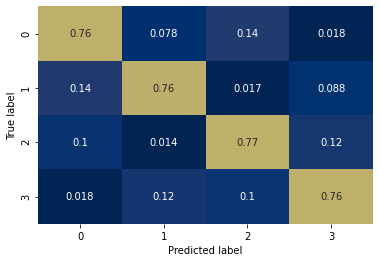

In [53]:
y = []
for n in range(len(v_c)):
    for i in range(len(seq)):
        if (v_c[n] == seq[i]).all():
                y.append(i)
                break

sns.heatmap(confusion_matrix(y, rbms[0].predict(v0,seq, beta = 60), normalize = "true"), annot=True, vmin = 0, vmax =1, cbar = False, yticklabels=list(range(4)), xticklabels=list(range(4)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

### Analysis on data generated from 5 sequences

In [54]:
q=0.2
fname = "DATA/dataRBM_seq5_q" + str(q) + ".csv"
v_5 = load(fname)

seqstr = ['11001100', '00111100', '11000011', '00110011', '11111111']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
v0_5 = v_5.copy()

In [55]:
q=0.2
fname = "DATA/dataRBM_clean5_q" + str(q) + ".csv"
v5_c = load(fname)

y_5_q02 = []
for n in range(len(v5_c)):
    for i in range(len(seq)):
        if (v5_c[n] == seq[i]).all():
                y_5_q02.append(i)
                break

In [56]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v_5))
    #plotgraph(*(my_rbm.params()), M=M)

In [57]:
M_score_b6 = []
M_score_b15 = []
M_score_b30 = []
for rb in rbms:
    M_score_b6.append(rb.score(v_5,seq, beta = 6))
    M_score_b15.append(rb.score(v_5,seq, beta = 30))
    M_score_b30.append(rb.score(v_5,seq, beta = 100))

/home/filippo/Documents/POD/LOCPB/Week5/RBM.py:140: RuntimeWarning: overflow encountered in exp
  prob = 1./(1.+np.exp(-beta*DE*act))


In [58]:
M_compare_b6 = []
M_compare_b15 = []
M_compare_b30 = []
for rb in rbms:
    M_compare_b6.append(rb.compare(v0_5,v5_c, beta = 6))
    M_compare_b15.append(rb.compare(v0_5,v5_c, beta = 30))
    M_compare_b30.append(rb.compare(v0_5,v5_c, beta = 100))

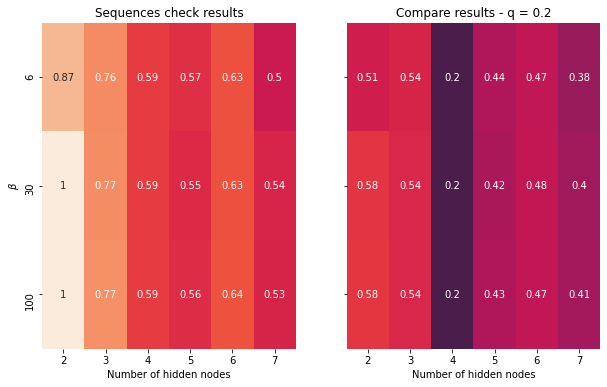

In [59]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
matr_score = [M_score_b6,M_score_b15,M_score_b30]
matr_compare = [M_compare_b6,M_compare_b15,M_compare_b30]
sns.heatmap(matr_score, annot=True, cbar = False, ax = ax[0], yticklabels=[6,30,100] , xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
sns.heatmap(matr_compare, annot=True, cbar = False, ax = ax[1], yticklabels=[6,30,100], xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
ax[0].set_xlabel("Number of hidden nodes")
ax[1].set_xlabel("Number of hidden nodes")
ax[0].set_title("Sequences check results")
ax[1].set_title("Compare results - q = 0.2")
ax[0].set_ylabel(r"$\beta$")
plt.show()

In general, results keep dropping as the complexity of the sequences increases. In this case, the only RBM that reaches the 1 check score is the one with two hidden nodes, but his actual performance tops at 0.58. The 3-node machine has a similar compare score. 

There is not a strong hypothesis for the reason why the 4-node RBM has such a bad performance, as it recognises the sequences randomly.

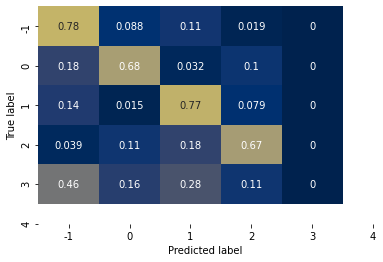

In [60]:
sns.heatmap(confusion_matrix(y_5_q02, rbms[0].predict(v0_5,seq, beta = 28), normalize = "true"), annot=True, cbar = False, vmin = 0, vmax =1, yticklabels=list(range(-1,5)), xticklabels=list(range(-1,5)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

Notice that as we saw for the case with $q=0.1$ the 2 hidden layer architecture is able to denoise correctly only data that belongs to the four initial classes making a sort of "overfitting" error.  

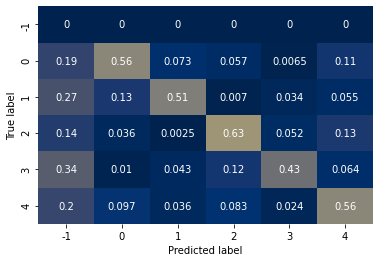

In [61]:
sns.heatmap(confusion_matrix(y_5_q02, rbms[1].predict(v0_5,seq, beta = 100), normalize = "true"), annot=True, cbar = False, vmin = 0, vmax =1, yticklabels=list(range(-1,5)), xticklabels=list(range(-1,5)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

The 3-node RBM has similar performance for every initial label. Nevertheless the overall performances drop because of the increased $q$ parameter

### Analysis on data generated from 6 sequences

In [62]:
q=0.2
fname = "DATA/dataRBM_seq6_q" + str(q) + ".csv"
v_6 = load(fname)

seqstr = ['11001100', '00111100', '11000011', '00110011', '11111111',  '10101000']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
v0_6 = v_6.copy()


In [63]:
q=0.2
fname = "DATA/dataRBM_clean6_q" + str(q) + ".csv"
v6_c = load(fname)

y_6_q02 = []
for n in range(len(v6_c)):
    for i in range(len(seq)):
        if (v6_c[n] == seq[i]).all():
                y_6_q02.append(i)
                break

In [64]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v_6))
    #plotgraph(*(my_rbm.params()), M=M)

In [65]:
M_score_b6 = []
M_score_b15 = []
M_score_b30 = []
for rb in rbms:
    M_score_b6.append(rb.score(v_6,seq, beta = 6))
    M_score_b15.append(rb.score(v_6,seq, beta = 30))
    M_score_b30.append(rb.score(v_6,seq, beta = 100))

In [66]:
M_compare_b6 = []
M_compare_b15 = []
M_compare_b30 = []
for rb in rbms:
    M_compare_b6.append(rb.compare(v0_6,v6_c, beta = 6))
    M_compare_b15.append(rb.compare(v0_6,v6_c, beta = 30))
    M_compare_b30.append(rb.compare(v0_6,v6_c, beta = 100))

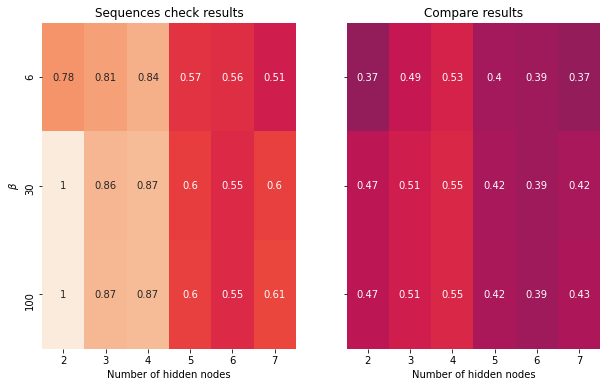

In [67]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
matr_score = [M_score_b6,M_score_b15,M_score_b30]
matr_compare = [M_compare_b6,M_compare_b15,M_compare_b30]
sns.heatmap(matr_score, annot=True, cbar = False, ax = ax[0], yticklabels=[6,30,100] , xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
sns.heatmap(matr_compare, annot=True, cbar = False, ax = ax[1], yticklabels=[6,30,100], xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
ax[0].set_xlabel("Number of hidden nodes")
ax[1].set_xlabel("Number of hidden nodes")
ax[0].set_title("Sequences check results")
ax[1].set_title("Compare results")
ax[0].set_ylabel(r"$\beta$")
plt.show()

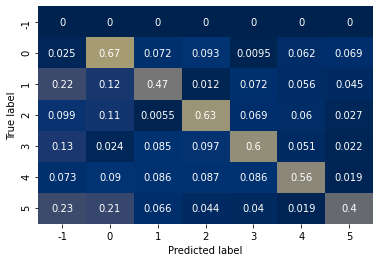

In [68]:
sns.heatmap(confusion_matrix(y_6_q02, rbms[2].predict(v0_6,seq, beta = 100), normalize = "true"), annot=True, cbar = False, vmin = 0, vmax =1, yticklabels=list(range(-1,6)), xticklabels=list(range(-1,6)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

Also for the six seqences case the performances decrease. 
It is noticeable that the best M value is in this case 4, while in the previous case it was the worst one. 

## Analysis with spins = False

In this section we are going to compare the performace of the RBM for different types of data. Using SPINS=TRUE we analized data in which the bit values were $1$ and $-1$. Now we will use $1$ and $0$ as bit states.

In [69]:
q=0.1
fname = "DATA/dataRBM_seq4_q" + str(q) + ".csv"
v2 = load(fname, spins = False)
#store initial values
v20 = v2.copy()

In [70]:
seqstr = ['11001100', '00111100', '11000011', '00110011']
seq2 = [[int(i) for i in seqstr[j]] for j in range(len(seqstr))]

In [71]:
q=0.1
fname = "DATA/dataRBM_clean4_q" + str(q) + ".csv"
v2_c = load(fname, spins = False)

y_2 = []
for n in range(len(v2_c)):
    for i in range(len(seq2)):
        if (v2_c[n] == seq2[i]).all():
                y_2.append(i)
                break

In [72]:
my_rbm2 = rbm.RBM(M=2, random_state = 123)
my_rbm2.fit(v2)

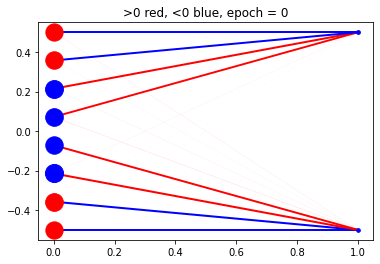

In [73]:
plotgraph(*(my_rbm2.params()), M=2)

From the graph one can see that the final configuration of weights for SPINS=FALSE resembles the one obtained with SPINS=TRUE.

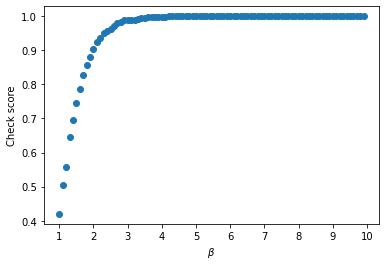

In [74]:
betas = list(np.arange(1,10,0.1))

scores_b = []
for beta in betas:
    scores_b.append(my_rbm2.score(v20, seq2, beta = beta))
    
plt.scatter(betas, scores_b, marker = 'o')
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Check score')
plt.show()

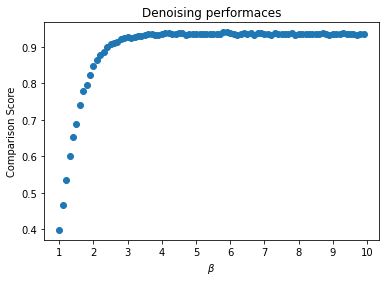

In [75]:
scores_comp = []
for beta in betas:
    scores_comp.append(my_rbm2.compare(v20,v2_c, beta = beta))

plt.scatter(betas, scores_comp)
plt.title('Denoising performaces')
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Comparison Score')
plt.show()

In [76]:
q=0.1
fname = "DATA/dataRBM_seq4_q" + str(q) + ".csv"
v = load(fname)
#store initial values
v0 = v.copy()

In [77]:
seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2 - 1 for i in seqstr[j]] for j in range(len(seqstr))]

In [78]:
q=0.1
fname = "DATA/dataRBM_clean4_q" + str(q) + ".csv"
v_c = load(fname)

y = []
for n in range(len(v_c)):
    for i in range(len(seq)):
        if (v_c[n] == seq[i]).all():
                y.append(i)
                break

In [79]:
my_rbm = rbm.RBM(M=2)
my_rbm.fit(v)

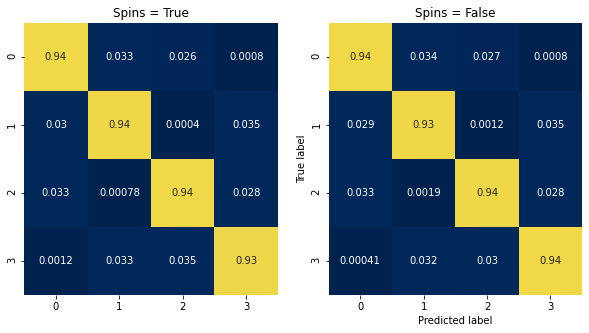

In [80]:
fig,ax = plt.subplots(1,2, figsize = (10,5))
sns.heatmap(confusion_matrix(y, my_rbm.predict(v0,seq, beta = 60), normalize = "true"), annot=True, ax =ax[0], vmin = 0, vmax =1, cbar = False, yticklabels=list(range(0,4)), xticklabels=list(range(0,4)), cmap = "cividis")
sns.heatmap(confusion_matrix(y_2, my_rbm2.predict(v20,seq2, beta = 60), normalize = "true"), annot=True,ax =ax[1], vmin = 0, vmax =1, cbar = False, yticklabels=list(range(0,4)), xticklabels=list(range(0,4)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")
ax[0].set_title("Spins = True")
ax[1].set_title("Spins = False")

plt.show()

Using spins True or False, yields the same results in terms of accuracy. The difference between the two methods can be searched looking at the speed of convergence of the algorithm. One idea is to look at the trend of $dw^2$

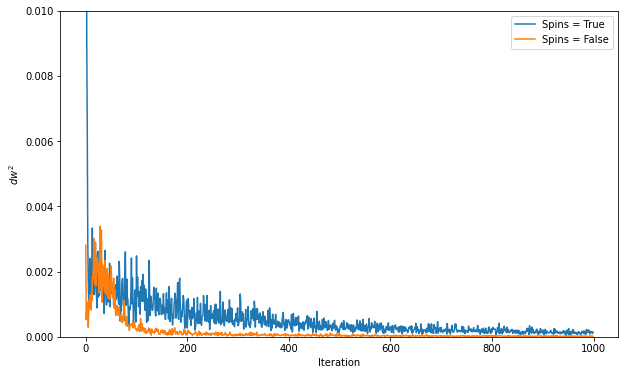

In [81]:
fig = plt.figure(figsize =(10,6))
plt.plot(range(1000),my_rbm.dw_history, label = "Spins = True")
plt.plot(range(1000),my_rbm2.dw_history, label = "Spins = False")
plt.ylim(0,0.01)
plt.xlabel("Iteration")
plt.ylabel(r"$dw^2$")
plt.legend()
plt.show()

From $dw^2$ trend, one can see that the configuration with SPINS=FALSE seems to converge faster, while the other seems to bounce more before reaching an effective convergence.

If we  now focus on the check score and compare results we can see that the using different spins has some remarkable effects on the score trends.

In [82]:
score2 = []
compare2 = []
for ep in range(2,50):
    my_rbm2 = rbm.RBM(M=2, nepochs = ep)
    my_rbm2.fit(v2)
    score2.append(my_rbm2.score(v2, seq2, beta = 100))
    compare2.append(my_rbm2.compare(v20,v2_c, beta = 100))

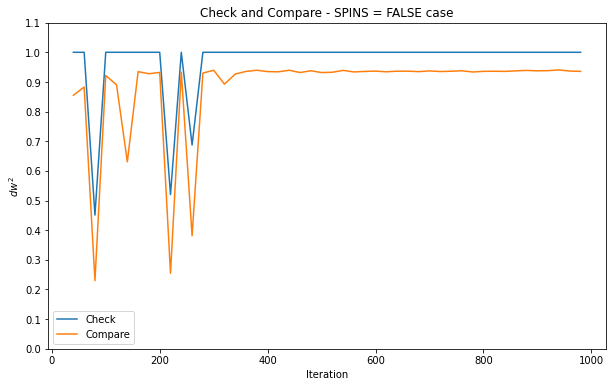

In [83]:
fig = plt.figure(figsize =(10,6))
plt.plot(np.arange(2,50)*20,score2, label = "Check")
plt.plot(np.arange(2,50)*20,compare2, label = "Compare")
plt.xlabel("Iteration")
plt.ylabel(r"$dw^2$")
plt.title("Check and Compare - SPINS = FALSE case")
plt.ylim(0,1.1)
plt.yticks(np.arange(0, 1.2, 0.1))
plt.legend()
plt.show()

As shown, using SPINS=FALSE has a highly noisy behaviour when we look at compare and check scores. Even if from the $dw^2$ trend it was possibile to address to such method a better convergence overall, it is necessary to notice now how these small changes have some rather large effects - the results are deeply affected by noise. 

Let's check now whether how the other case performs.

In [84]:
score = []
compare = []
for ep in range(2,50):
    my_rbm = rbm.RBM(M=2, nepochs = ep)
    my_rbm.fit(v)
    score.append(my_rbm.score(v, seq, beta = 100))
    compare.append(my_rbm.compare(v0,v_c, beta = 100))

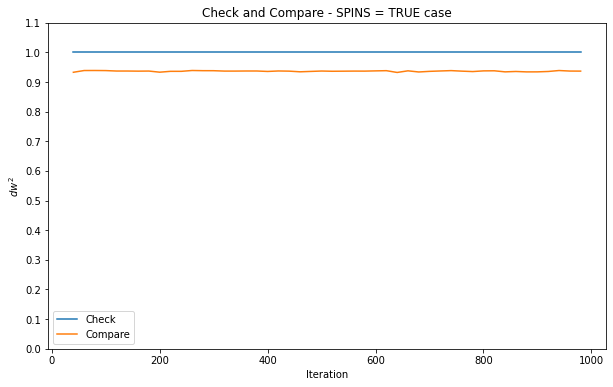

In [85]:
fig = plt.figure(figsize =(10,6))
plt.plot(np.arange(2,50)*20,score, label = "Check")
plt.plot(np.arange(2,50)*20,compare, label = "Compare")
plt.xlabel("Iteration")
plt.ylabel(r"$dw^2$")
plt.title("Check and Compare - SPINS = TRUE case")
plt.ylim(0,1.1)
plt.yticks(np.arange(0, 1.2, 0.1))
plt.legend()

The SPINS=TRUE case instead has a smoother behaviour. Even if the convergence is slower, the performances of the algorithm stays constant within all epochs. 

So, it is now clear the importance of using the spins: even if the parameters converge in more epochs, they all remain in the same range of perfomances without any major noise - this effect makes the algoritm stable, and there's actually no need for running it up to 1000 epochs!

Moreover, the performances of both cases are similar, if not completely compatible. 